- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [ ]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    !git pull


- enable module autoreload and fix an import bug

In [1]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [2]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from DataGenerator import DataGenerator

In [ ]:
database = "data2"

_batch_size = 8

train_img_tile_files = sorted(glob.glob(f'{database}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database}/train/WBC_mask/tiles/*.jpg'))

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/WBC_mask/tiles/*.jpg'))


train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, None, _batch_size, skip_empty = True, noise_prob = 0)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, None, _batch_size, skip_empty = True, augment=False)

#train = model.generate_train_dataset(train_img_files)

#train_generator = model.generate_train_dataset(train_img_files)

#train_set = model.generate_train_dataset_tf(train_img_files)



#test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset(test_img_files)

#train_img_chips, train_mask_chips, train_edge_chips = model.generate_test_dataset(train_img_files)



#test_set = model.generate_test_dataset_tf(test_img_files)


- load the model and compile it

In [4]:
_model_name = "WBC_binaryCrossEntrophy_no_noise_15"

In [5]:
objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}


unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

unet.compile(optimizer="adam",
             loss="BinaryCrossentropy",
             metrics=[model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'])

#unet.summary()

- load the training log 

In [5]:
#save the training log into a file
import json

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

- predict full image

In [6]:
images_path = sorted(glob.glob(f'ALL-IDB1/*.jpg'))[:5]

In [7]:
images, masks = model.predictFullImage(unet,
                          data.load_data_na(images_path, RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False,
                        edge=False)

2022-06-20 12:01:54.311295: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 425115648 exceeds 10% of free system memory.
2022-06-20 12:01:55.239534: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 425115648 exceeds 10% of free system memory.


 1/10 [==>...........................] - ETA: 1:57

2022-06-20 12:02:05.569830: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 425115648 exceeds 10% of free system memory.
2022-06-20 12:02:06.161922: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 425115648 exceeds 10% of free system memory.


 2/10 [=====>........................] - ETA: 56s 

2022-06-20 12:02:12.688459: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 425115648 exceeds 10% of free system memory.


10/10 [==============================] - 97s 10s/step


- CCL

17

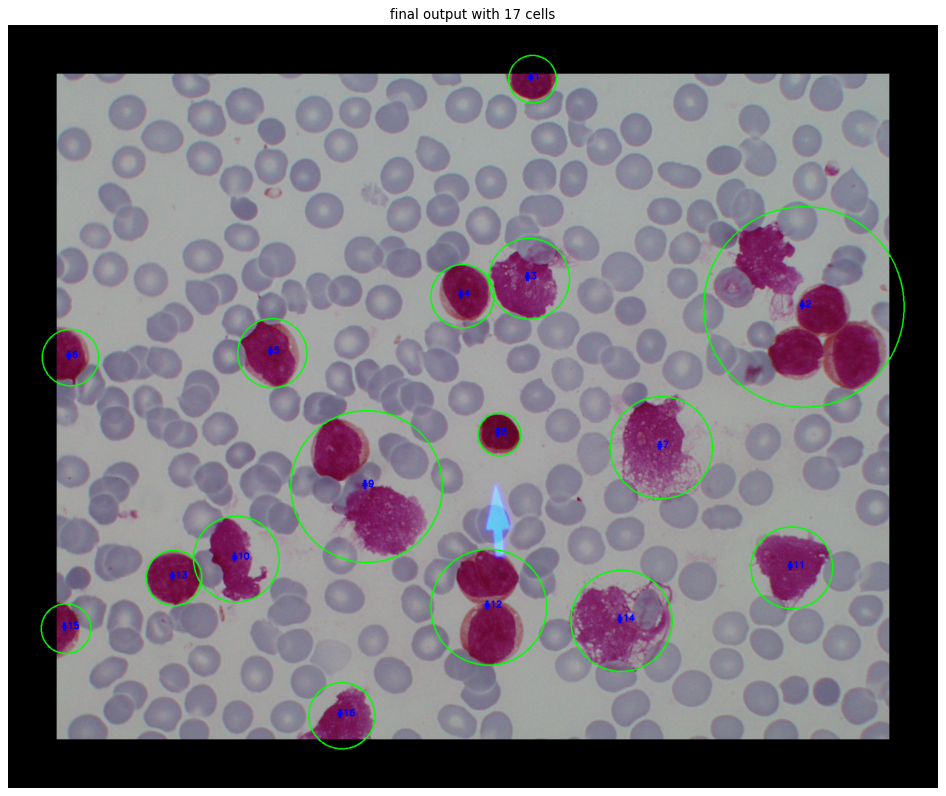

In [8]:
from scripts import postProcessing

original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)

ind = 1

postProcessing.CCL_Count(original_images[ind], masks[ind], plot=False, min_filter_size=1000)

- Circle Hough Transform

found 37 circles before cleaning
found 20 circles after cleaning


20

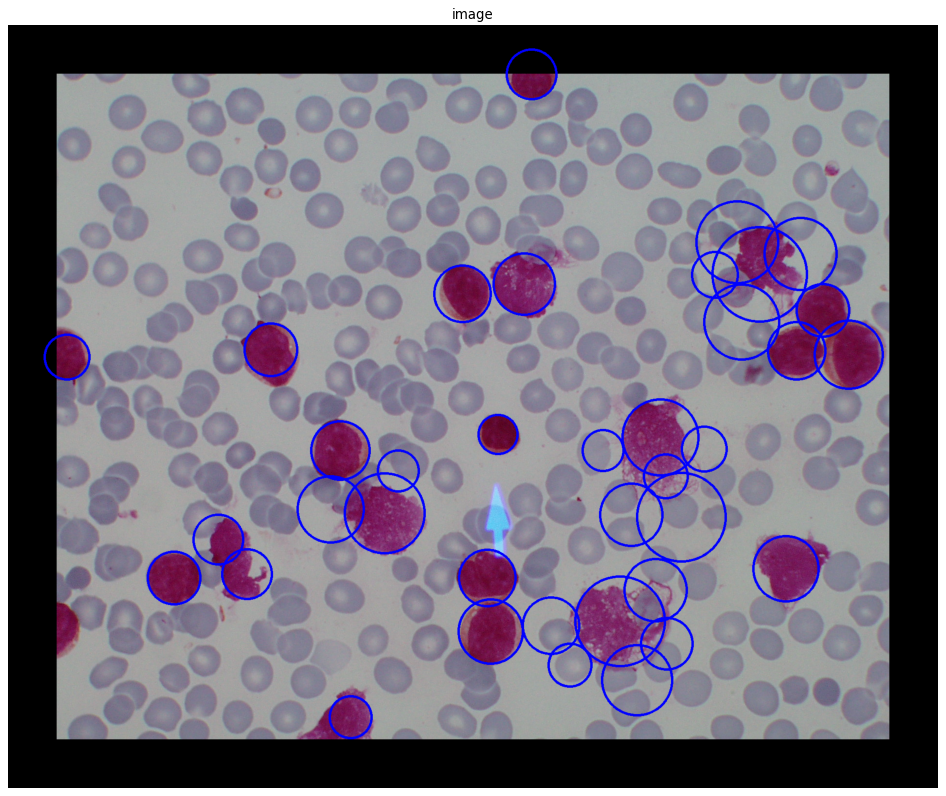

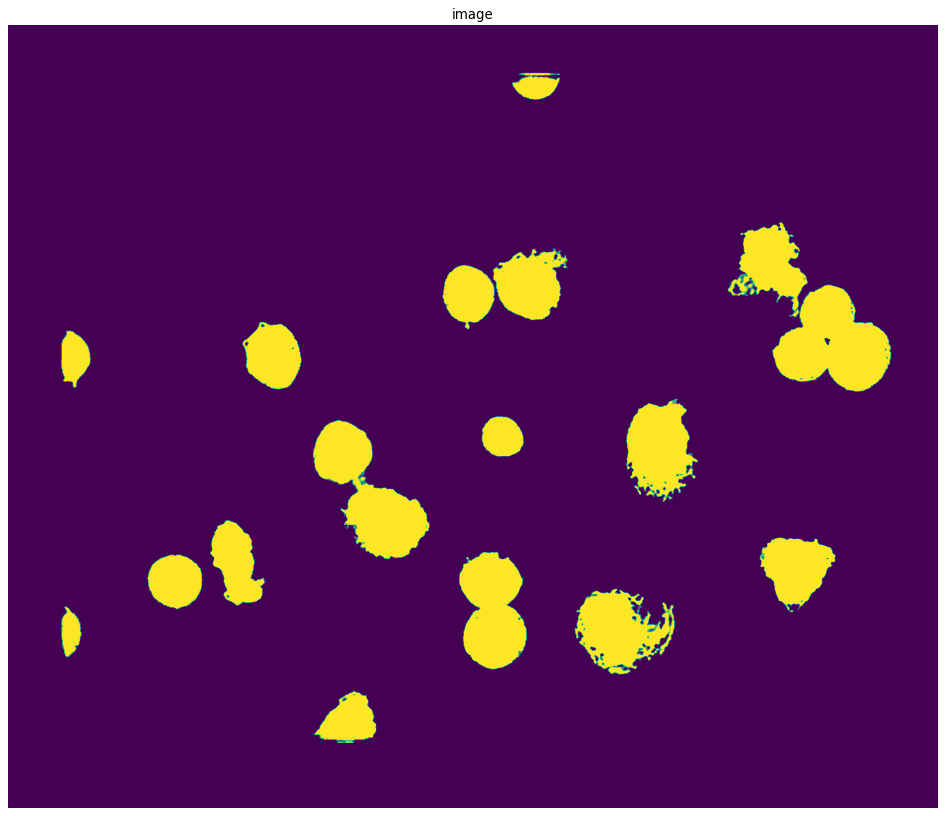

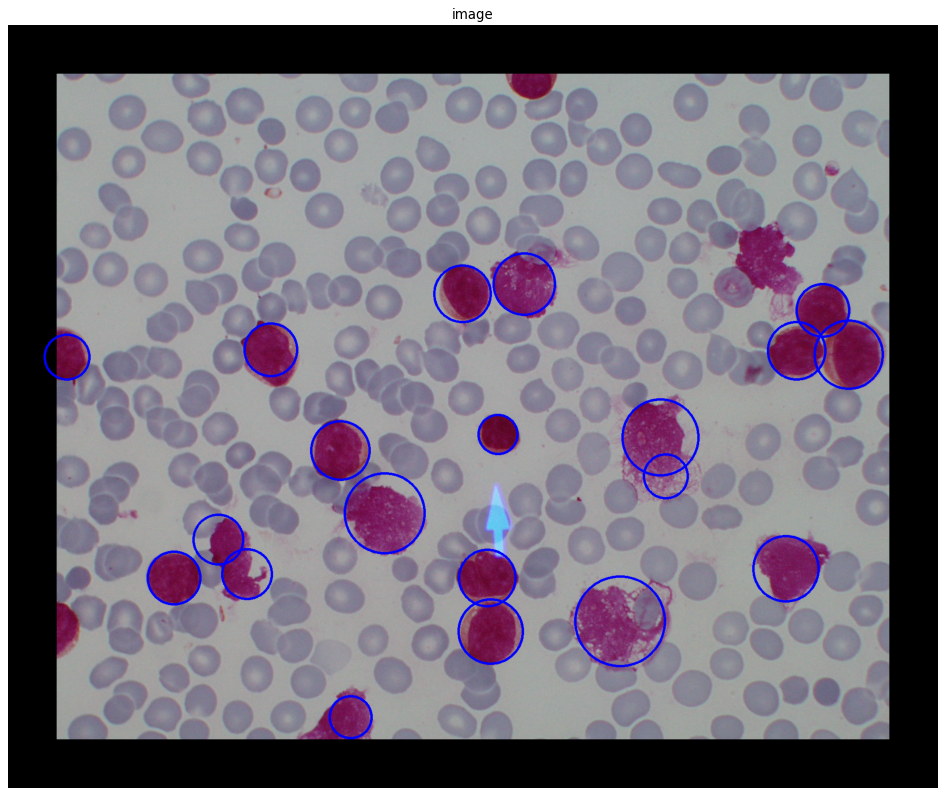

In [11]:
from scripts import postProcessing

original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)

ind = 1

postProcessing.CHT_Count(original_images[ind], masks[ind], plot=False, min_filter_size=1000, param1 = 500, param2 = 7.6, min_dist=80, threshold = 60)

- Watershed


In [6]:
from scripts import postProcessing

images_path = sorted(glob.glob(f'ALL-IDB1/*.jpg'))[:1]


In [7]:
postProcessing.WBC_Count(images_path, unet)

AttributeError: module 'data' has no attribute 'load_data_na'

In [ ]:
data.plot_ime(images,
              masks,
              masks,
              figSize=(25,15),
              max_plots = 40)

- apply some postProcessing methods to segment the touched cells 

In [11]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils

In [8]:
from scripts import postProcessing

In [25]:
images_path

['ALL-IDB1/Im001_1.jpg',
 'ALL-IDB1/Im002_1.jpg',
 'ALL-IDB1/Im003_1.jpg',
 'ALL-IDB1/Im004_1.jpg',
 'ALL-IDB1/Im005_1.jpg']

In [26]:
original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)[20]
#for i in range(len(original_images)):
i= 4
print(f"counting WBC's in image {images_path[i]}")
ret = postProcessing.Watershed_Count(original_images, masks[i], plot = True, min_filter_size=1000, threshold_type="binary")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7375/1306776845.py", line 1, in <module>
    original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)[20]
  File "/media/root/8C68F6B168F698E22/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py", line 160, in load_data_na
  File "/media/root/8C68F6B168F698E22/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py", line 116, in preprocess_data_na
  File "/media/root/8C68F6B168F698E22/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py", line 116, in <listcomp>
  File "<__array_function__ internals>", line 5, in pad
  File "/usr/lib/python3/dist-packages/numpy/lib/arraypad.py", line 743, in pad
    pad_width = _as_pairs(pad_width, array.ndim, as_index=True)
  File "/usr/lib/python3/dist-packages/numpy/lib/arraypad.py", line 518, in _as_pairs
    return np.br

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7375/1306776845.py", line 1, in <module>
    original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)[20]
  File "/media/root/8C68F6B168F698E22/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py", line 160, in load_data_na
  File "/media/root/8C68F6B168F698E22/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py", line 116, in preprocess_data_na
  File "/media/root/8C68F6B168F698E22/WorkSpace/DEEP LEARNING/MY-U-NET/scripts/data.py", line 116, in <listcomp>
  File "<__array_function__ internals>", line 5, in pad
  File "/usr/lib/python3/dist-packages/numpy/lib/arraypad.py", line 743, in pad
    pad_width = _as_pairs(pad_width, array.ndim, as_index=True)
  File "/usr/lib/python3/dist-packages/numpy/lib/arraypad.py", line 518, in _as_pairs
    return np.br

[  0   1   2   3  29  33  34  40  42  44  45  46  47  60  81  82  83  84
  86  87  89  97  99 109 110 111 113 117 128 131 132 138 140 146 170 171
 173 193 195 196 197 200]
[INFO] 44 unique segments found


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


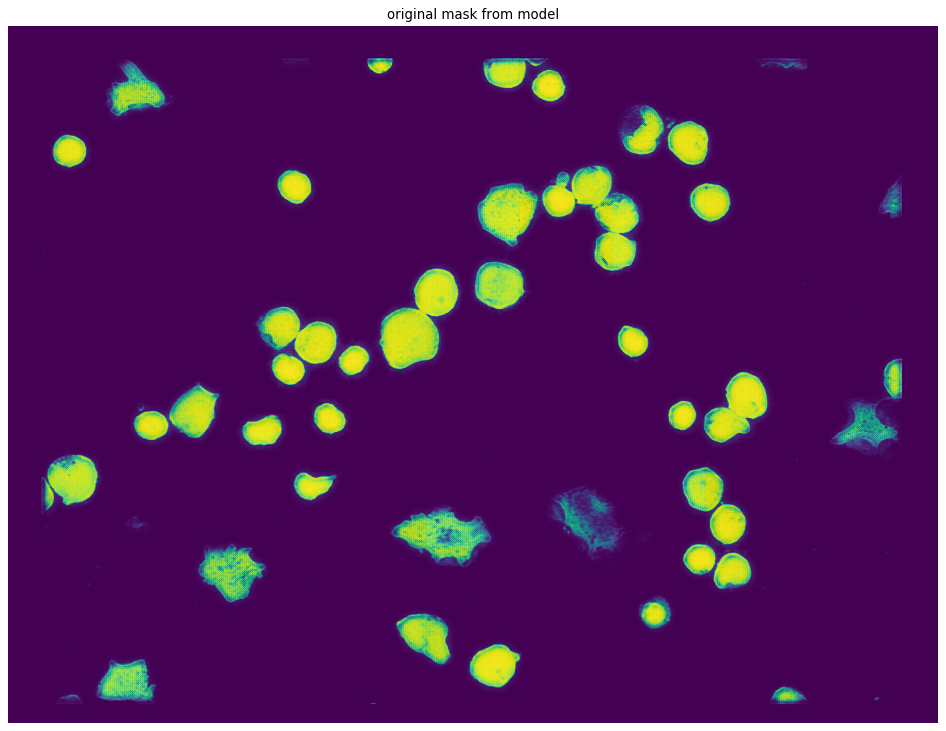

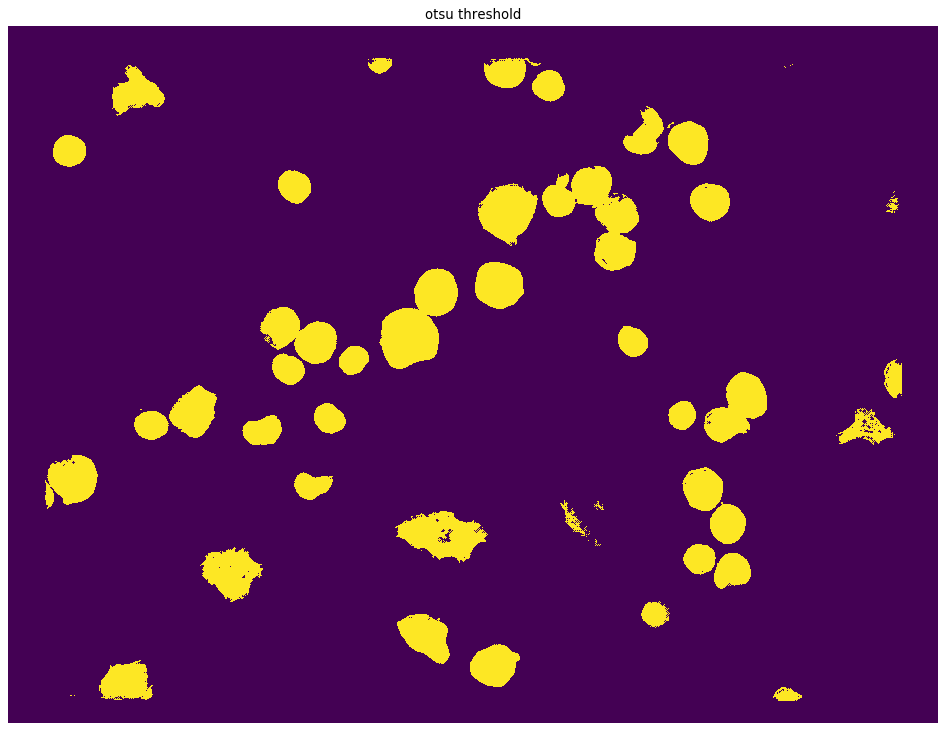

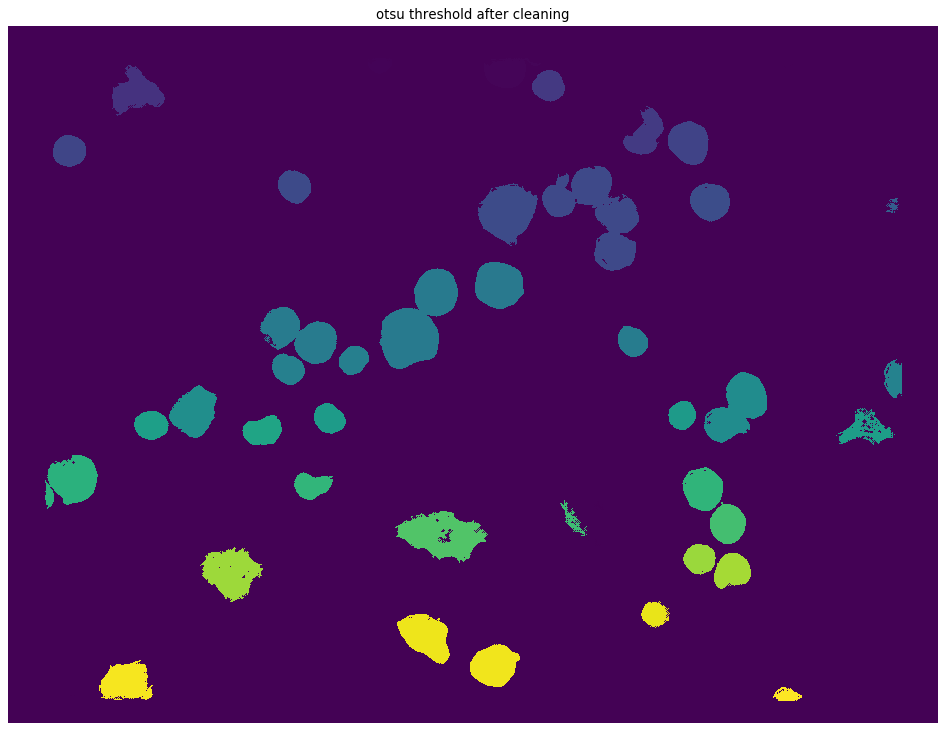

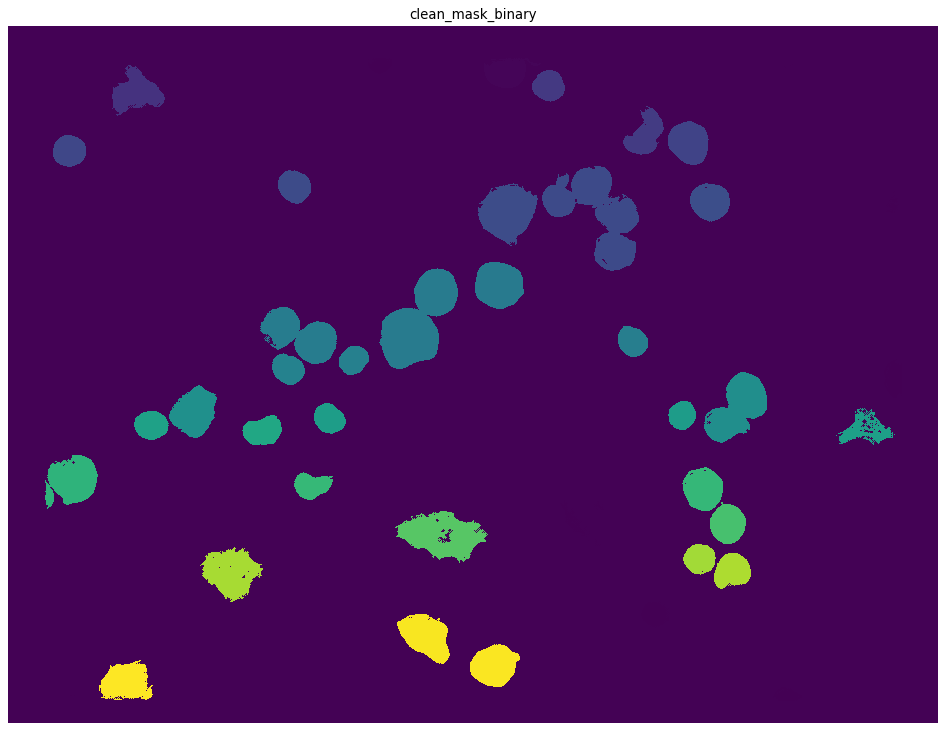

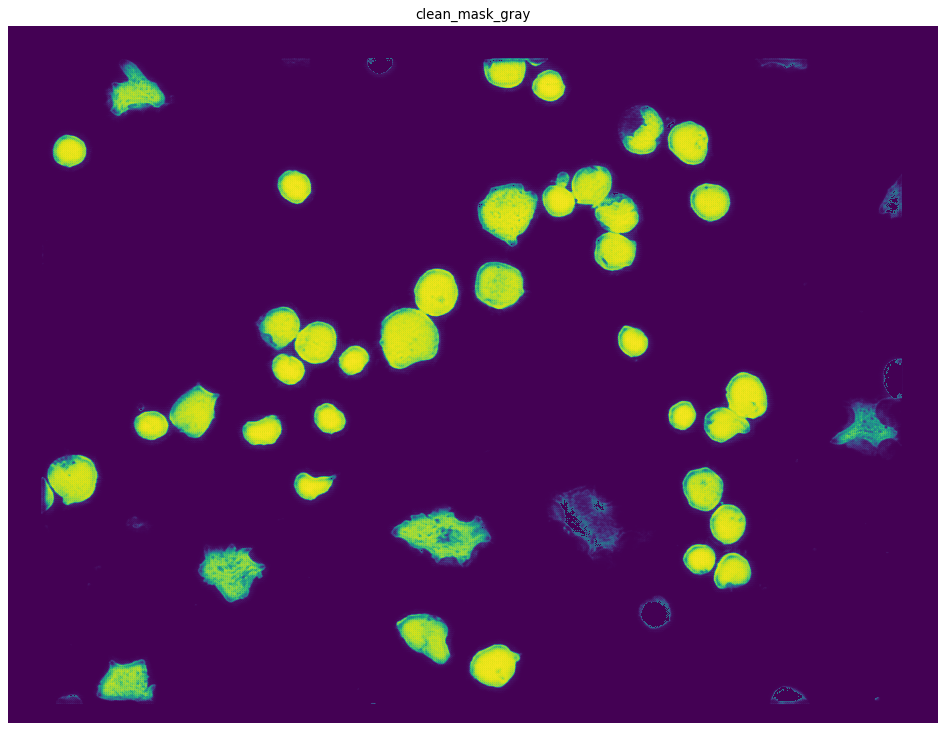

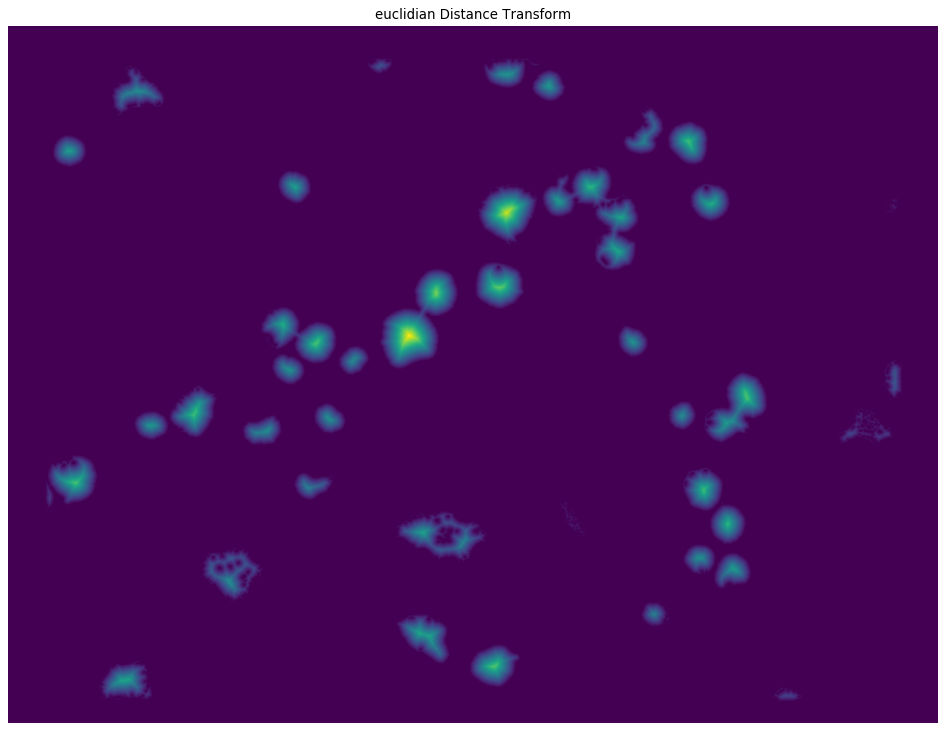

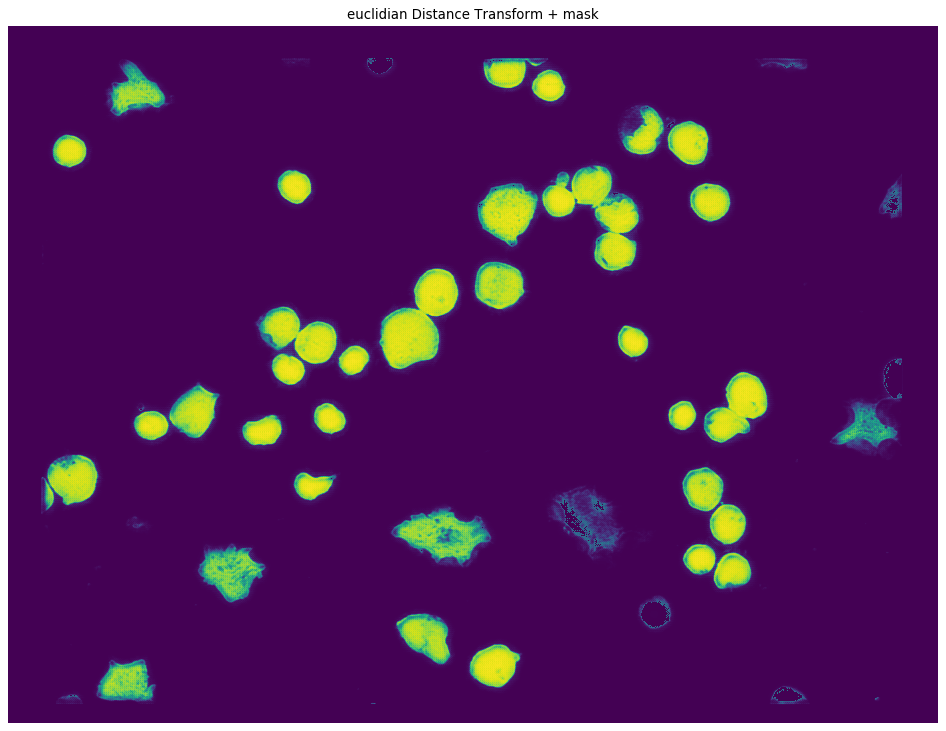

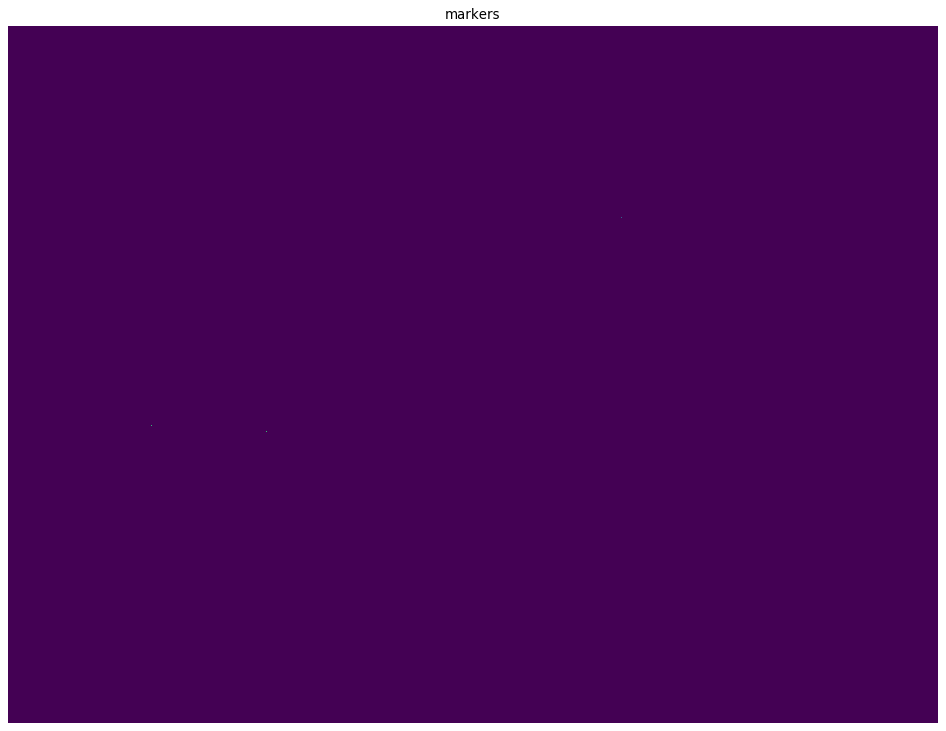

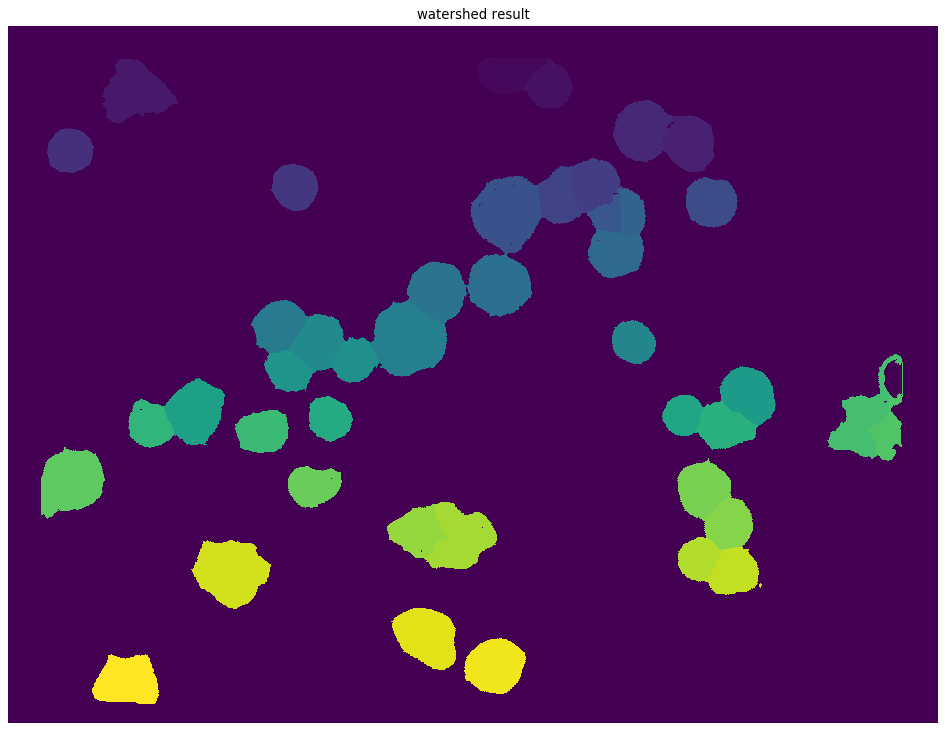

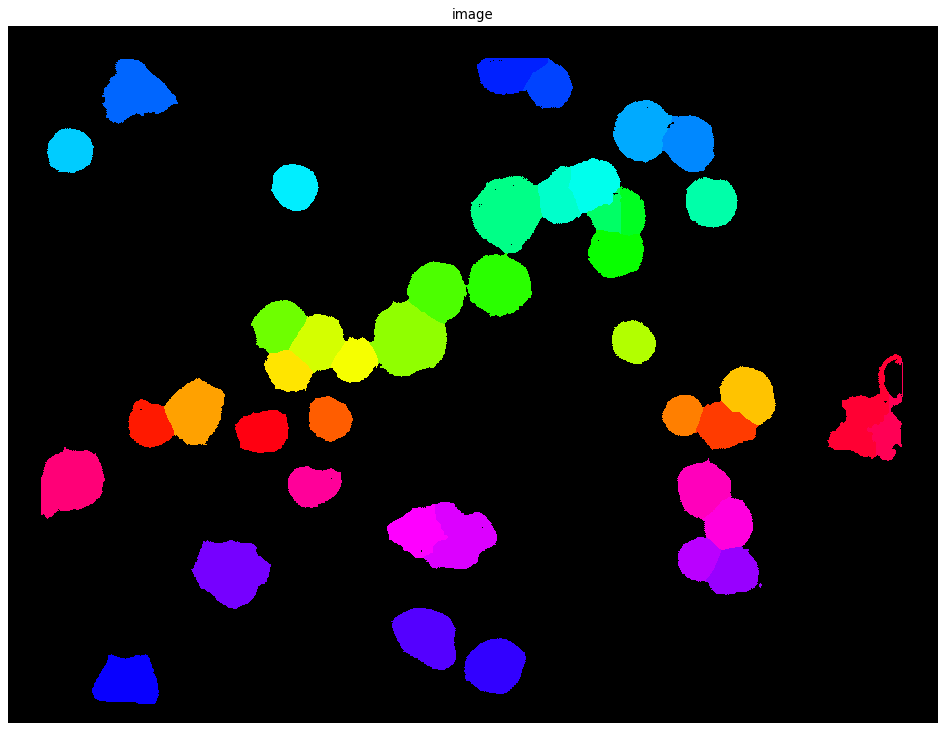

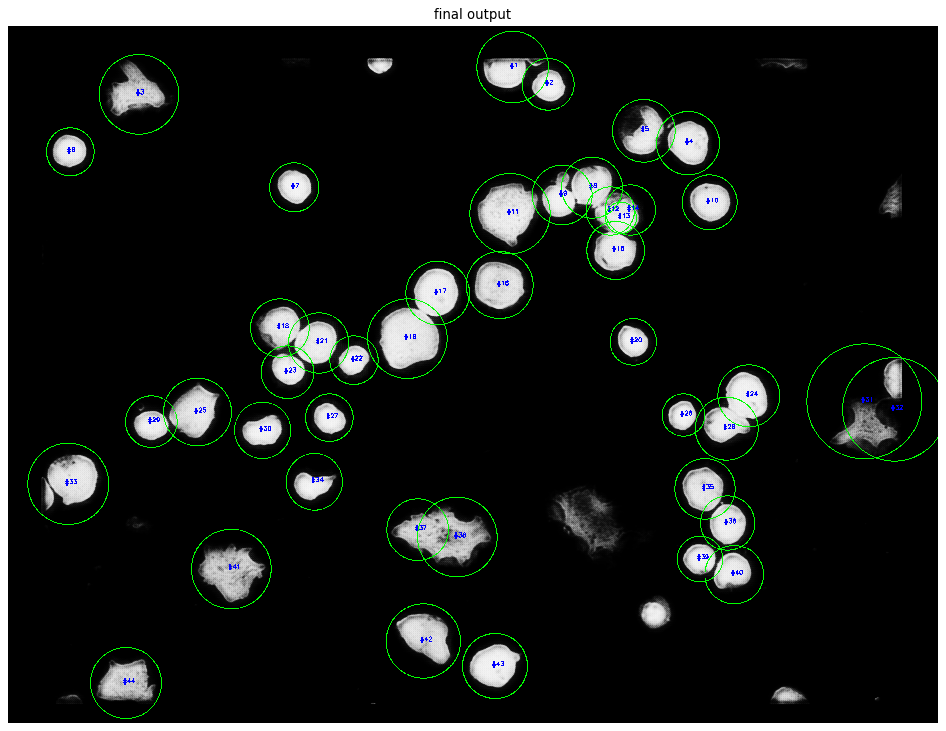

In [17]:
ind = 2
test_image = images[ind]
test_mask = masks[ind]

import cv2

#data.showImg(test_image)
data.showImg(test_mask, "original mask from model")

ret2, mask_gray_otsu = cv2.threshold((test_mask * 255.0).astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

clean_mask_binary = data.surfaceFilter((mask_gray_otsu).astype(np.uint8), min_size= 5000, colorize=False, gray=True)

#clean_mask_binary_no_color = #(clean_mask_binary > 0) * 255.0).astype(np.uint8)

clean_mask_gray = cv2.bitwise_or(test_mask, test_mask, mask=(clean_mask_binary.astype(np.uint8)))
clean_mask_gray = (clean_mask_gray * 255.0).astype(np.uint8)


data.showImg(mask_gray_otsu, title="otsu threshold")

clean_mask_gray_otsu = data.surfaceFilter(mask_gray_otsu, min_size= 500, colorize=False, gray=True)

data.showImg(clean_mask_gray_otsu, title="otsu threshold after cleaning")


#data.showImg(clean_mask_gray > 0.5, title="clean_mask threshhold")
data.showImg(clean_mask_binary, title="clean_mask_binary")
#data.showImg(clean_mask_binary_no_color, title="clean_mask_binary_no_color")
data.showImg(clean_mask_gray, title="clean_mask_gray")

print(np.unique(clean_mask_gray_otsu))

#distance transform on the mask
D = ndimage.distance_transform_edt((clean_mask_gray_otsu > 1) * 255.0)

DT_with_mask = (D * 10) + (clean_mask_gray * 255.0)

data.showImg(D, title="euclidian Distance Transform")
data.showImg(DT_with_mask, title="euclidian Distance Transform + mask")


localMax = peak_local_max(D, 
                          indices=False, 
                          min_distance=50, 
                          labels=clean_mask_binary)


# perform a connected component analysis on the local peaks to label each local maxima with a num,
# using 8-connectivity, then appy the Watershed algorithm we can also use connected component labeling
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]

#same image as local maxima
data.showImg(markers, title="markers")

labels = watershed(-D, markers, mask=((clean_mask_gray)))

print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

data.showImg(labels, title="watershed result")

data.showImg(data.colorize_unique(labels))


#loop over the unique labels returned by the Watershed
# algorithm
image_orig = cv2.cvtColor(test_mask.copy(), cv2.COLOR_GRAY2RGB)
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(test_mask.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image_orig, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image_orig, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
data.showImg(image_orig, title="final output")

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')